In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, log_loss
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


selected_columns = ['CustomerID', 'Start Year', 'Cleaned_Insured name', 'Policy Start Date', 'Policy End Date', 'Reg no ',
       'MANUFACTURER/Make', 'model', 'variant', 'Fuel Type', 'RTO Location ',
       'Product name ', 'Product name  2', 'biztype', 'Renewal Type', 'age',
       'Vehicle Segment', 'Number of Vehicles', 'Number of Policies',
       'Total Premium Payable (Overall)', 'Total OD Premium (Overall)',
       'Total TP Premium (Overall)', 'Total Add on Premium (Overall)',
       'Total GST (Overall)', 'Average Discount (Overall)',
       'Average NCB % Previous Year (Overall)', 'Number of Claims',
       'Number of Declines', 'New Branch Name  2', 'Policy Status', 'Not Renewed', 
       'Renewed','Open', 'Renewal Rate', 'Churn Label', 'New Customer', 'Customer Tenure ']

data = pd.read_excel('Actual data (South).xlsx')
data = data[selected_columns]

# Remove rows where 'Status' contains 'Open'
data = data[~data['Policy Status'].str.contains('Open', case=False, na=False)]

data = data[data['Policy Status'].str.contains('Renewed|Not Renewed', case=False, na=False)]

data['Churn Label'] = data['Churn Label'].apply(lambda x: 1 if x == 'Yes' else 0)

for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = data[column].fillna('missing')
    else:
        data[column] = data[column].fillna(0)

date_columns = ['Policy Start Date', 'Policy End Date']

for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

# Extract year, month, and day as separate features for all date columns
new_date_cols = {}
for col in date_columns:
    new_date_cols[f'{col}_YEAR'] = data[col].dt.year
    new_date_cols[f'{col}_MONTH'] = data[col].dt.month
    new_date_cols[f'{col}_DAY'] = data[col].dt.day

data = pd.concat([data, pd.DataFrame(new_date_cols)], axis=1)

most_recent_year = data['Policy Start Date_YEAR'].max()

test_data = data[(data['Policy Start Date_YEAR'] == most_recent_year) & 
                 (data['Policy Start Date_MONTH'] >= 6)]

train_data = data[~((data['Policy Start Date_YEAR'] == most_recent_year) & 
                    (data['Policy Start Date_MONTH'] >= 6))]

data = data.drop(columns=date_columns)

leaking_features = [
    'Not Renewed', 'Renewed','Open', 'Renewal Rate', 'Policy Status'
]

features = [col for col in data.columns if col not in leaking_features + ['Churn Label']]

X_train = train_data[features]
y_train = train_data['Churn Label']

X_test = test_data[features]
y_test = test_data['Churn Label']

In [3]:
from imblearn.over_sampling import RandomOverSampler

# Initialize RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Apply Random Oversampling to the training data
X_train, y_train = ros.fit_resample(X_train, y_train)

In [4]:
# Group by year and status to count occurrences in the training data
train_status_yearwise = train_data.groupby(['Policy Start Date_YEAR', 'Churn Label']).size().reset_index(name='Count')

# Group by year and status to count occurrences in the testing data
test_status_yearwise = test_data.groupby(['Policy Start Date_YEAR', 'Churn Label']).size().reset_index(name='Count')

# Print the results
print("Year-wise Status Counts in Training Data:")
print(train_status_yearwise)

print("\nYear-wise Status Counts in Testing Data:")
print(test_status_yearwise)

# Count the occurrences of 0 and 1 in the 'Status' column for train and test data
train_status_count = y_train.value_counts()
test_status_count = y_test.value_counts()

# Print the results
print("Training Data Status Counts:")
print(train_status_count)

print("\nTesting Data Status Counts:")
print(test_status_count)

Year-wise Status Counts in Training Data:
    Policy Start Date_YEAR  Churn Label  Count
0                     2018            0      1
1                     2019            0      2
2                     2019            1      1
3                     2020            0    114
4                     2020            1   1247
5                     2021            0    731
6                     2021            1     10
7                     2022            0  70528
8                     2022            1  85936
9                     2023            0  33159
10                    2023            1  43458

Year-wise Status Counts in Testing Data:
   Policy Start Date_YEAR  Churn Label  Count
0                    2023            0   9034
1                    2023            1  50072
Training Data Status Counts:
Churn Label
1    130652
0    130652
Name: count, dtype: int64

Testing Data Status Counts:
Churn Label
1    50072
0     9034
Name: count, dtype: int64


In [5]:
# Group by year and status to count occurrences in the training data
train_status_monthwise = train_data.groupby(['Policy Start Date_YEAR', 'Policy Start Date_MONTH', 'Churn Label']).size().reset_index(name='Count')

# Group by year and status to count occurrences in the testing data
test_status_monthwise = test_data.groupby(['Policy Start Date_YEAR', 'Policy Start Date_MONTH', 'Churn Label']).size().reset_index(name='Count')

# Print the results
print("Year-wise Status Counts in Training Data:")
print(train_status_monthwise)

print("\nYear-wise Status Counts in Testing Data:")
print(test_status_monthwise)

# Count the occurrences of 0 and 1 in the 'Status' column for train and test data
train_status_count = y_train.value_counts()
test_status_count = y_test.value_counts()

# Print the results
print("Training Data Status Counts:")
print(train_status_count)

print("\nTesting Data Status Counts:")
print(test_status_count)

Year-wise Status Counts in Training Data:
    Policy Start Date_YEAR  Policy Start Date_MONTH  Churn Label  Count
0                     2018                        8            0      1
1                     2019                        8            0      1
2                     2019                        8            1      1
3                     2019                       12            0      1
4                     2020                        1            0      7
..                     ...                      ...          ...    ...
69                    2023                        3            1  10951
70                    2023                        4            0   5796
71                    2023                        4            1   8071
72                    2023                        5            0   6806
73                    2023                        5            1   8176

[74 rows x 4 columns]

Year-wise Status Counts in Testing Data:
   Policy Start Date_YEAR  Po

In [6]:
# Apply label encoding to categorical features for both train and test sets
for column in X_train.columns:
    if X_train[column].dtype == 'object':
        # Initialize and fit the LabelEncoder on the training data
        label_encoder = LabelEncoder()
        X_train[column] = label_encoder.fit_transform(X_train[column].astype(str))

        # Create a mapping dictionary from the LabelEncoder
        mapping_dict = {label: i for i, label in enumerate(label_encoder.classes_)}
        
        # Track the next unique integer for unseen values in the test set
        next_unique_value = [max(mapping_dict.values()) + 1]  

        # Encode the test data
        def encode_test_value(value):
            if value in mapping_dict:
                return mapping_dict[value]
            else:
                # Update the mapping_dict with a new unique value for unseen categories
                mapping_dict[value] = next_unique_value[0]
                next_unique_value[0] += 1
                return mapping_dict[value]

        # Apply the encoding to the test set
        X_test[column] = X_test[column].apply(encode_test_value)

C:\Users\Admin\AppData\Local\Temp\ipykernel_13412\1072933455.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[column] = X_test[column].apply(encode_test_value)
C:\Users\Admin\AppData\Local\Temp\ipykernel_13412\1072933455.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[column] = X_test[column].apply(encode_test_value)
C:\Users\Admin\AppData\Local\Temp\ipykernel_13412\1072933455.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

Test Accuracy: 0.6444523398639732
Test Log Loss: 0.4669209055699065
Test ROC AUC: 0.7857040333913851
Test Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.84      0.42      9034
           1       0.95      0.61      0.74     50072

    accuracy                           0.64     59106
   macro avg       0.62      0.72      0.58     59106
weighted avg       0.85      0.64      0.69     59106

Train Accuracy: 0.8651570584453357
Train Log Loss: 0.30120706516648776
Train ROC AUC: 0.9412582523323387
Train Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87    130652
           1       0.89      0.84      0.86    130652

    accuracy                           0.87    261304
   macro avg       0.87      0.87      0.87    261304
weighted avg       0.87      0.87      0.87    261304



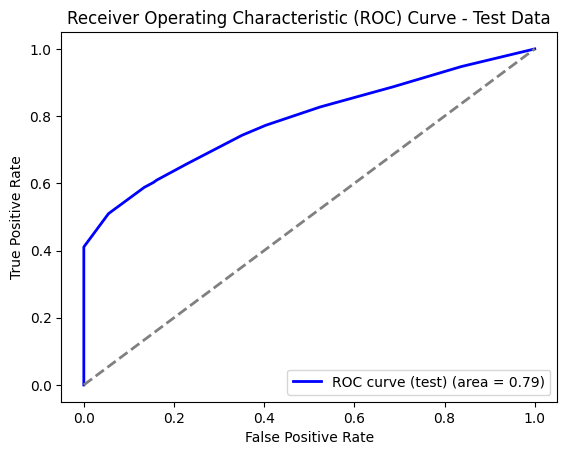

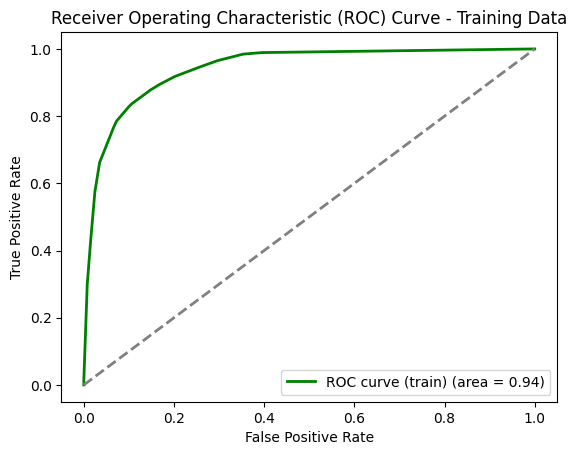

In [7]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and train the Decision Tree classifier
model = DecisionTreeClassifier(random_state=42, max_depth=5)
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7222955368321321
Test Log Loss: 10.00948341503348
Test ROC AUC: 0.6093825024795819
Test Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.45      0.33      9034
           1       0.89      0.77      0.82     50072

    accuracy                           0.72     59106
   macro avg       0.57      0.61      0.58     59106
weighted avg       0.79      0.72      0.75     59106

Train Accuracy: 1.0
Train Log Loss: 2.220446049250313e-16
Train ROC AUC: 1.0
Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    130652
           1       1.00      1.00      1.00    130652

    accuracy                           1.00    261304
   macro avg       1.00      1.00      1.00    261304
weighted avg       1.00      1.00      1.00    261304



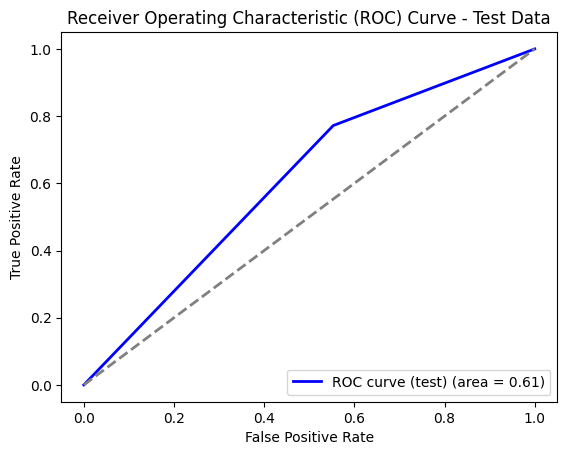

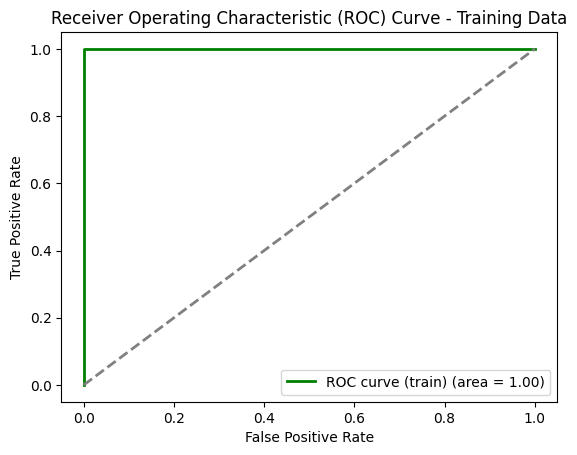

In [8]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and train the Decision Tree classifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.41769025141271615
Test Log Loss: 0.7710250381205213
Test ROC AUC: 0.41009622256414785
Test Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.40      0.17      9034
           1       0.80      0.42      0.55     50072

    accuracy                           0.42     59106
   macro avg       0.45      0.41      0.36     59106
weighted avg       0.69      0.42      0.49     59106

Class 0 Test Accuracy: 0.3991587336727917
Class 1 Test Accuracy: 0.42103371145550406
Train Accuracy: 0.8365390503015645
Train Log Loss: 0.3442884926387554
Train ROC AUC: 0.9156880931818139
Train Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.79      0.83    130652
           1       0.81      0.89      0.84    130652

    accuracy                           0.84    261304
   macro avg       0.84      0.84      0.84    261304
weighted avg       0.84      0.84      0.84    26130

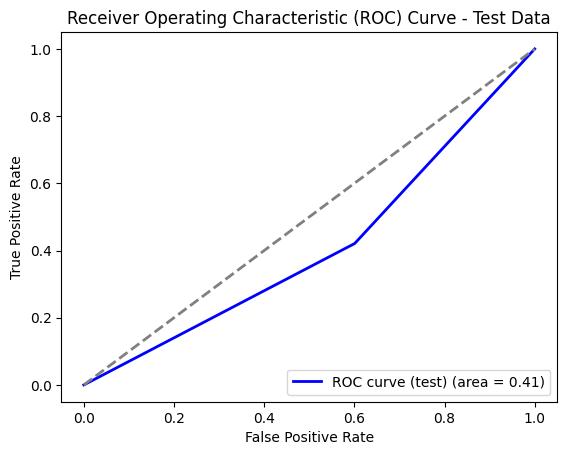

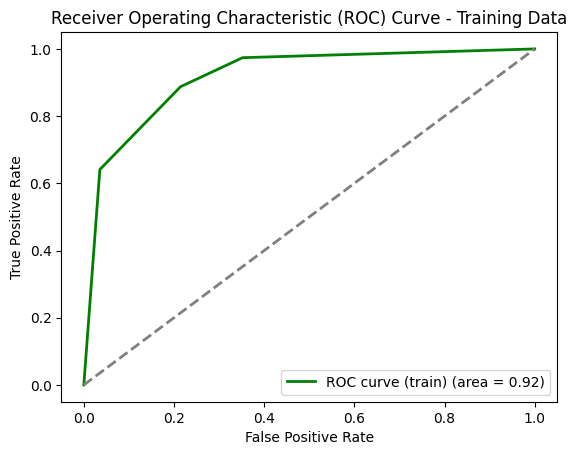

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

model = DecisionTreeClassifier(
    random_state=42,
    max_depth=8,                
    min_samples_split=20,       
    min_samples_leaf=10,        
    max_leaf_nodes=50,          
    ccp_alpha=0.01              
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.4581260785707035
Test Log Loss: 1.1820095587303427
Test ROC AUC: 0.787675000821487
Test Classification Report:
              precision    recall  f1-score   support

           0       0.22      1.00      0.36      9034
           1       1.00      0.36      0.53     50072

    accuracy                           0.46     59106
   macro avg       0.61      0.68      0.45     59106
weighted avg       0.88      0.46      0.50     59106

Class 0 Test Accuracy: 1.0
Class 1 Test Accuracy: 0.3603610800447356
Train Accuracy: 0.6587652695710743
Train Log Loss: 0.6231048343656957
Train ROC AUC: 0.9435952423611264
Train Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.99      0.74    130652
           1       0.98      0.32      0.49    130652

    accuracy                           0.66    261304
   macro avg       0.79      0.66      0.62    261304
weighted avg       0.79      0.66      0.62    261304

Class 0 Train Ac

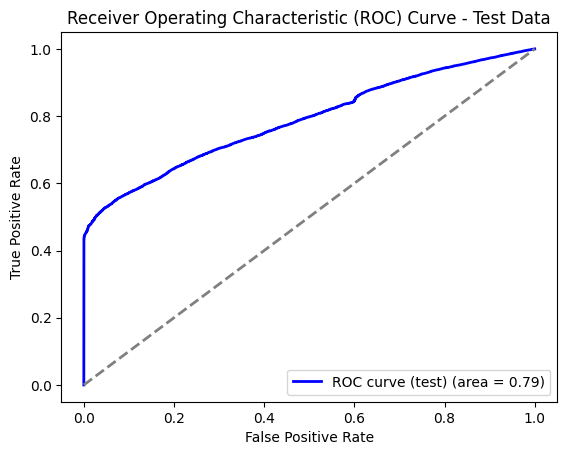

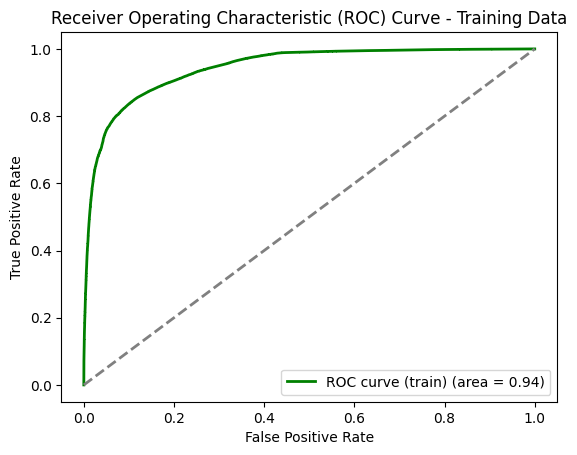

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_split=20,
    min_samples_leaf=10,
    max_leaf_nodes=50,
    class_weight={0: 10, 1: 1},  
    random_state=42
)
# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.808039792914425
Test Log Loss: 0.4185333052591231
Test ROC AUC: 0.8094608872809163
Test Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.38      0.37      9034
           1       0.89      0.89      0.89     50072

    accuracy                           0.81     59106
   macro avg       0.63      0.63      0.63     59106
weighted avg       0.81      0.81      0.81     59106

Train Accuracy: 0.999996173039831
Train Log Loss: 0.06204954853663497
Train ROC AUC: 0.9999999999121262
Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    130652
           1       1.00      1.00      1.00    130652

    accuracy                           1.00    261304
   macro avg       1.00      1.00      1.00    261304
weighted avg       1.00      1.00      1.00    261304



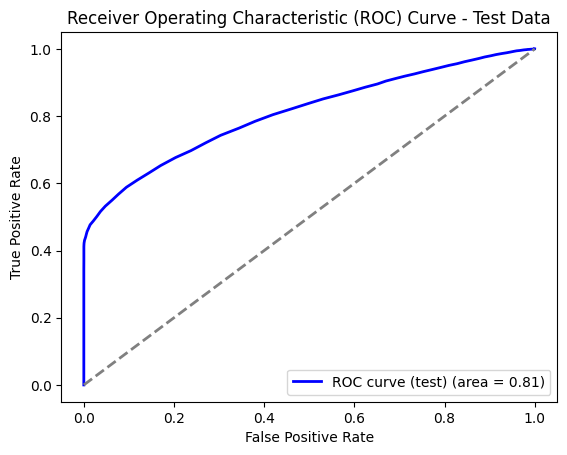

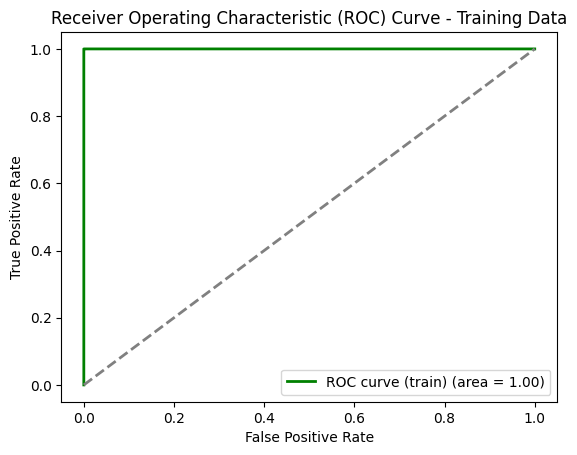

In [11]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and train the Decision Tree classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.513450411125774
Test Log Loss: 0.9562968496670669
Test ROC AUC: 0.7920939408465006
Test Classification Report:
              precision    recall  f1-score   support

           0       0.24      1.00      0.39      9034
           1       1.00      0.43      0.60     50072

    accuracy                           0.51     59106
   macro avg       0.62      0.71      0.49     59106
weighted avg       0.88      0.51      0.56     59106

Class 0 Test Accuracy: 0.9998893070622095
Class 1 Test Accuracy: 0.4256870107045854
Train Accuracy: 0.8036654624498668
Train Log Loss: 0.48733018663424943
Train ROC AUC: 0.9447696555990049
Train Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.98      0.83    130652
           1       0.96      0.63      0.76    130652

    accuracy                           0.80    261304
   macro avg       0.84      0.80      0.80    261304
weighted avg       0.84      0.80      0.80    261304



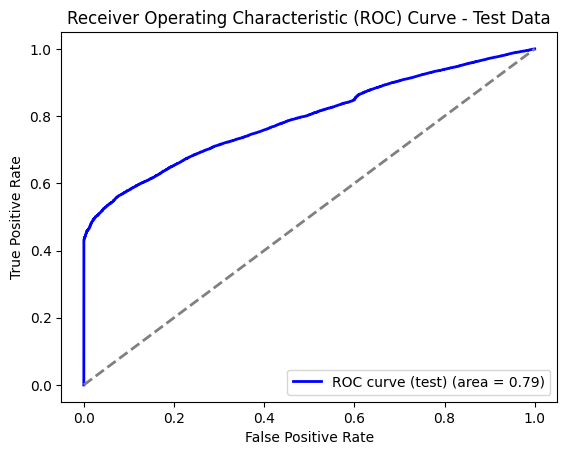

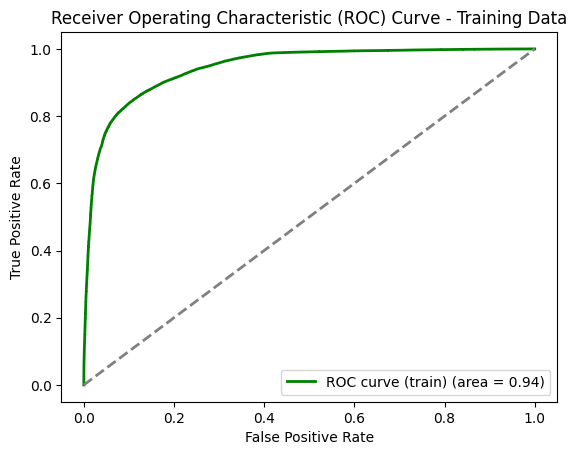

In [12]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_split=20,
    min_samples_leaf=10,
    max_leaf_nodes=50,
    class_weight={0: 5, 1: 1},  
    random_state=42
)

from sklearn.metrics import confusion_matrix

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.781189726931276
Test Log Loss: 0.5363068463239541
Test ROC AUC: 0.7785030766676724
Test Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.40      0.36      9034
           1       0.89      0.85      0.87     50072

    accuracy                           0.78     59106
   macro avg       0.61      0.63      0.61     59106
weighted avg       0.80      0.78      0.79     59106

Train Accuracy: 0.8679048158466767
Train Log Loss: 0.3478923930197191
Train ROC AUC: 0.9452089488395111
Train Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87    130652
           1       0.86      0.88      0.87    130652

    accuracy                           0.87    261304
   macro avg       0.87      0.87      0.87    261304
weighted avg       0.87      0.87      0.87    261304



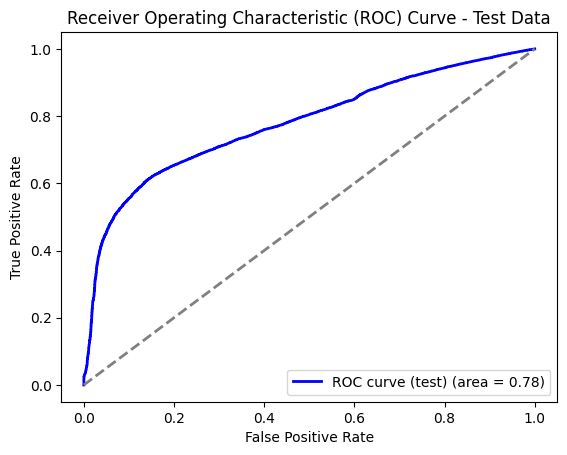

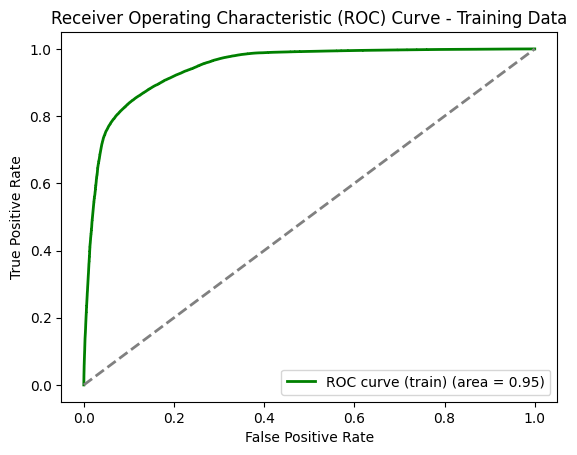

In [13]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest model
model = RandomForestClassifier(
    n_estimators=100,             
    max_depth=8,                  
    min_samples_split=20,         
    min_samples_leaf=10,          
    max_leaf_nodes=50,            
    class_weight='balanced',      
    random_state=42
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.2942340879098569
Test Log Loss: 1.0521975982893321
Test ROC AUC: 0.7891320790733471
Test Classification Report:
              precision    recall  f1-score   support

           0       0.18      1.00      0.30      9034
           1       1.00      0.17      0.29     50072

    accuracy                           0.29     59106
   macro avg       0.59      0.58      0.29     59106
weighted avg       0.87      0.29      0.29     59106

Train Accuracy: 0.6800929185929033
Train Log Loss: 0.5493745719337091
Train ROC AUC: 0.9368993306107588
Train Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.99      0.76    130652
           1       0.97      0.37      0.54    130652

    accuracy                           0.68    261304
   macro avg       0.79      0.68      0.65    261304
weighted avg       0.79      0.68      0.65    261304



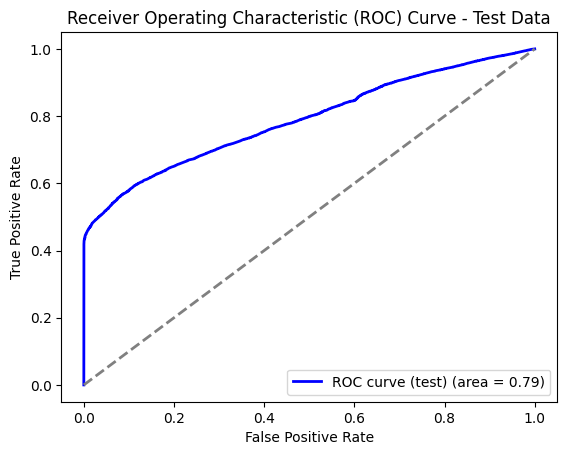

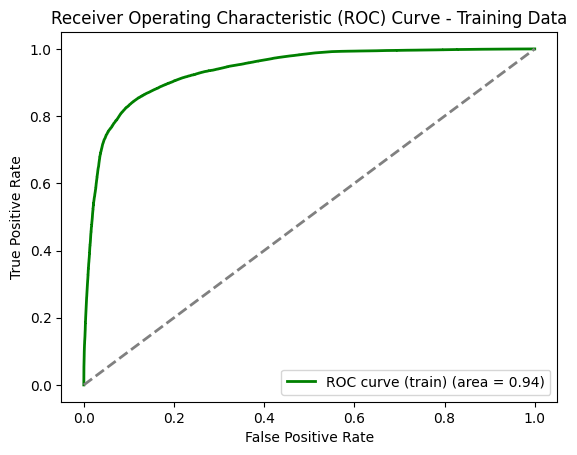

In [14]:
model = RandomForestClassifier(
    n_estimators=50,  
    max_depth=6,     
    min_samples_split=50,
    min_samples_leaf=20,
    max_leaf_nodes=30,
    class_weight={0: 5, 1: 1},
    random_state=42
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Accuracy: 0.4952796670388793
Test Log Loss: 0.7283473429601665
Test ROC AUC: 0.5795661906805496
Test Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.64      0.28      9034
           1       0.88      0.47      0.61     50072

    accuracy                           0.50     59106
   macro avg       0.53      0.56      0.45     59106
weighted avg       0.77      0.50      0.56     59106

Train Accuracy: 0.6150269417995897
Train Log Loss: 0.6564315059346031
Train ROC AUC: 0.6574017547584493
Train Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.60      0.61    130652
           1       0.61      0.63      0.62    130652

    accuracy                           0.62    261304
   macro avg       0.62      0.62      0.61    261304
weighted avg       0.62      0.62      0.61    261304



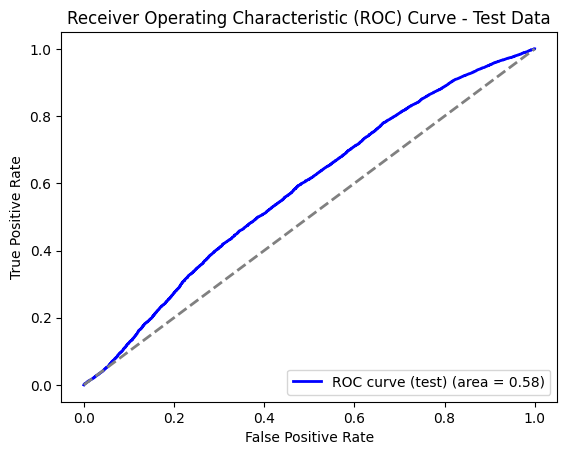

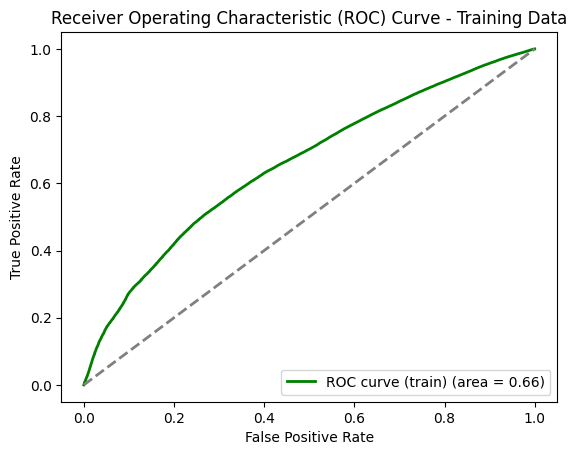

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt

# Initialize Logistic Regression model
model = LogisticRegression(
    max_iter=1000,   
    random_state=42
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Test Accuracy: 0.5366460257841843
Test Log Loss: 0.6928189200351461
Test ROC AUC: 0.5128189825513336
Test Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.66      0.30      9034
           1       0.89      0.52      0.65     50072

    accuracy                           0.54     59106
   macro avg       0.54      0.59      0.48     59106
weighted avg       0.79      0.54      0.60     59106

Train Accuracy: 0.5119554235679515
Train Log Loss: 0.693146947390686
Train ROC AUC: 0.5000191348008449
Train Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.64      0.57    130652
           1       0.52      0.38      0.44    130652

    accuracy                           0.51    261304
   macro avg       0.51      0.51      0.50    261304
weighted avg       0.51      0.51      0.50    261304



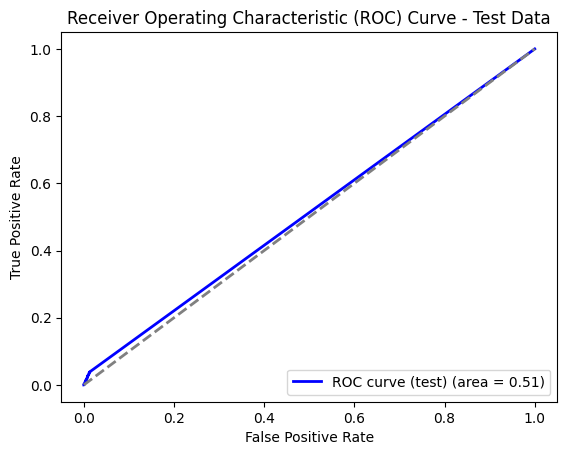

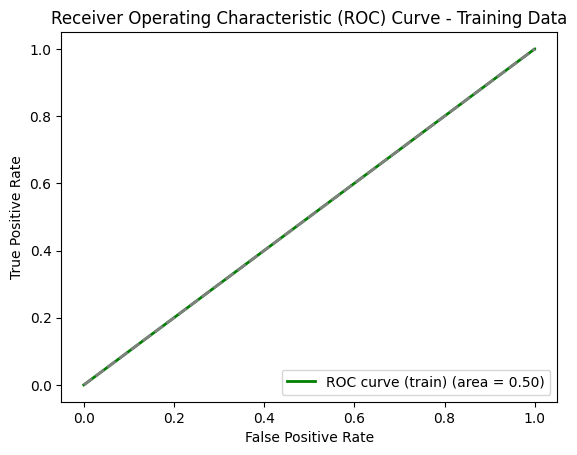

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, log_loss
import matplotlib.pyplot as plt

# Initialize and train the SVM model
model = SVC(probability=True, kernel='linear', max_iter=1000)  
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.6151490542415322
Test Log Loss: 1.6259305358837959
Test ROC AUC: 0.5015477037838593
Test Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.31      0.20      9034
           1       0.84      0.67      0.75     50072

    accuracy                           0.62     59106
   macro avg       0.49      0.49      0.47     59106
weighted avg       0.74      0.62      0.66     59106

Train Accuracy: 0.7506544101888988
Train Log Loss: 0.47904896630169796
Train ROC AUC: 0.8317358896000817
Train Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76    130652
           1       0.77      0.72      0.74    130652

    accuracy                           0.75    261304
   macro avg       0.75      0.75      0.75    261304
weighted avg       0.75      0.75      0.75    261304



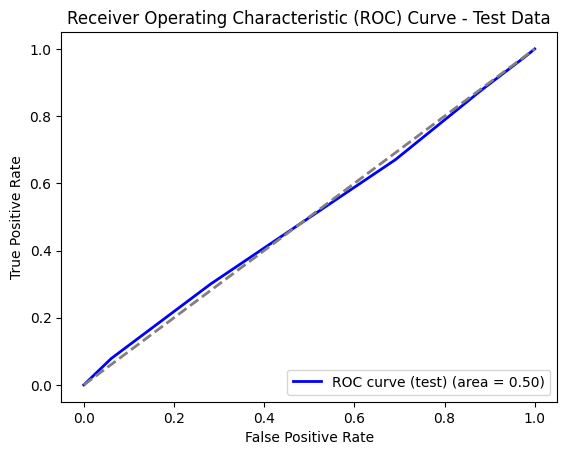

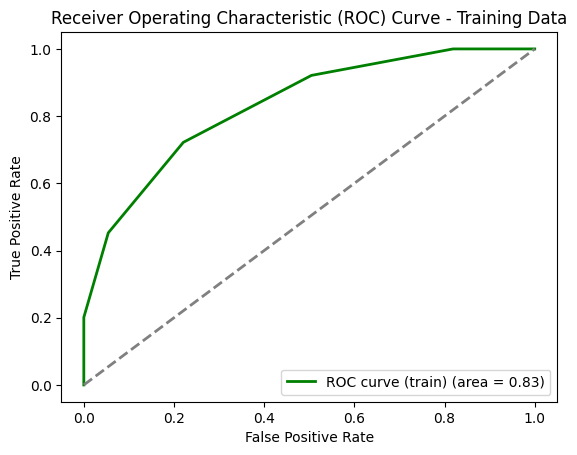

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, log_loss
import matplotlib.pyplot as plt

# Initialize and train the KNN model
model = KNeighborsClassifier(n_neighbors=5)  
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.5432612594322065
Test Log Loss: 1.43657479039007
Test ROC AUC: 0.5820287172568469
Test Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.58      0.28      9034
           1       0.88      0.54      0.67     50072

    accuracy                           0.54     59106
   macro avg       0.53      0.56      0.47     59106
weighted avg       0.77      0.54      0.61     59106

Train Accuracy: 0.6061522211676821
Train Log Loss: 0.9514349385240454
Train ROC AUC: 0.6821478766367801
Train Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.43      0.52    130652
           1       0.58      0.78      0.66    130652

    accuracy                           0.61    261304
   macro avg       0.62      0.61      0.59    261304
weighted avg       0.62      0.61      0.59    261304



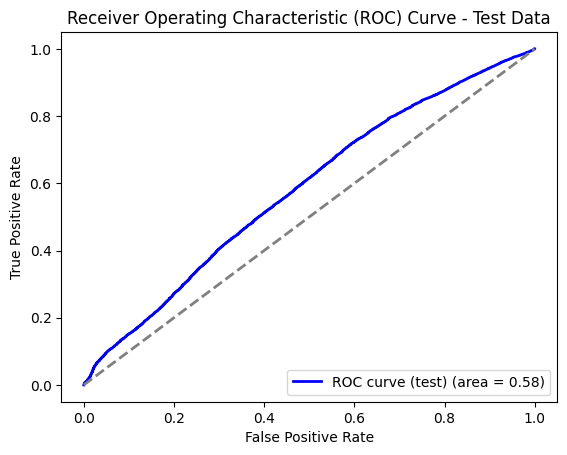

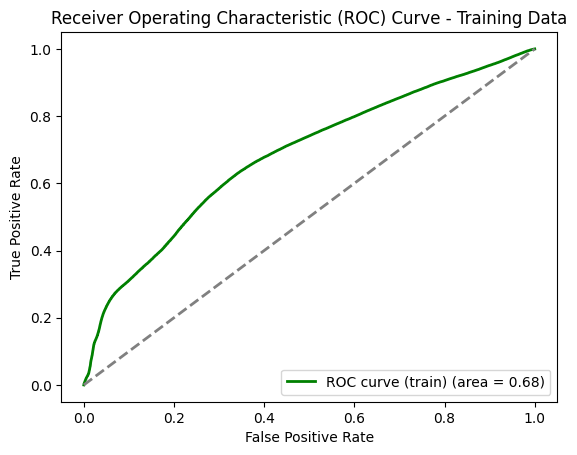

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB  
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, log_loss
import matplotlib.pyplot as plt

# Initialize and train the Naive Bayes model
model = GaussianNB() 
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.8047406354684804
Test Log Loss: 0.3595861499217687
Test ROC AUC: 0.8572632694728756
Test Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.65      0.51      9034
           1       0.93      0.83      0.88     50072

    accuracy                           0.80     59106
   macro avg       0.67      0.74      0.69     59106
weighted avg       0.85      0.80      0.82     59106

Train Accuracy: 0.8859336252028289
Train Log Loss: 0.2593216510948127
Train ROC AUC: 0.958813271705528
Train Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89    130652
           1       0.89      0.88      0.89    130652

    accuracy                           0.89    261304
   macro avg       0.89      0.89      0.89    261304
weighted avg       0.89      0.89      0.89    261304



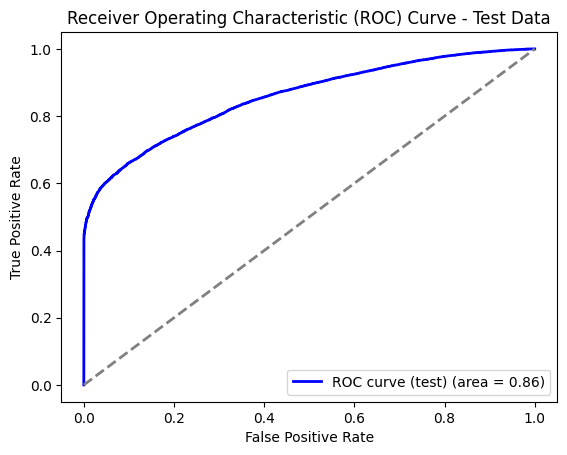

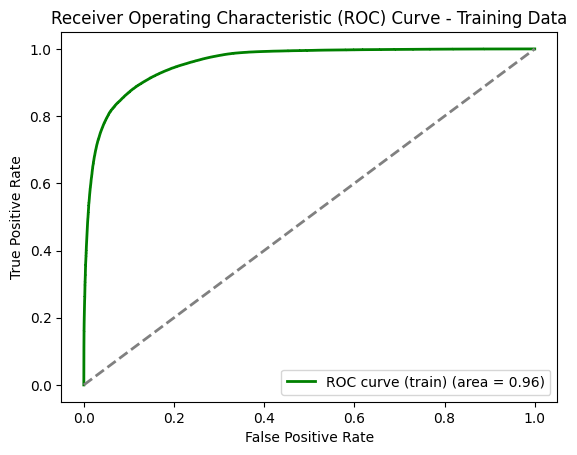

In [19]:
import xgboost as xgb

# XGBoost model
model = xgb.XGBClassifier(
    max_depth=6,                  
    learning_rate=0.1,            
    n_estimators=100,            
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), 
    random_state=42
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.8047406354684804
Test Log Loss: 0.3595861499217687
Test ROC AUC: 0.8572632694728756
Test Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.65      0.51      9034
           1       0.93      0.83      0.88     50072

    accuracy                           0.80     59106
   macro avg       0.67      0.74      0.69     59106
weighted avg       0.85      0.80      0.82     59106

Class 0 Test Accuracy: 0.6534204117777286
Class 1 Test Accuracy: 0.8320418597220003
Train Accuracy: 0.8859336252028289
Train Log Loss: 0.2593216510948127
Train ROC AUC: 0.958813271705528
Train Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89    130652
           1       0.89      0.88      0.89    130652

    accuracy                           0.89    261304
   macro avg       0.89      0.89      0.89    261304
weighted avg       0.89      0.89      0.89    261304

C

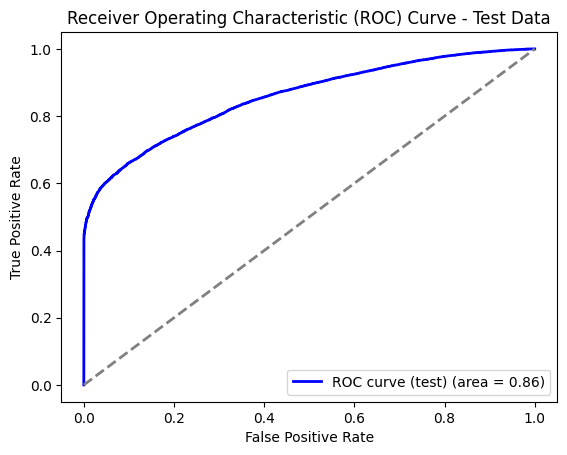

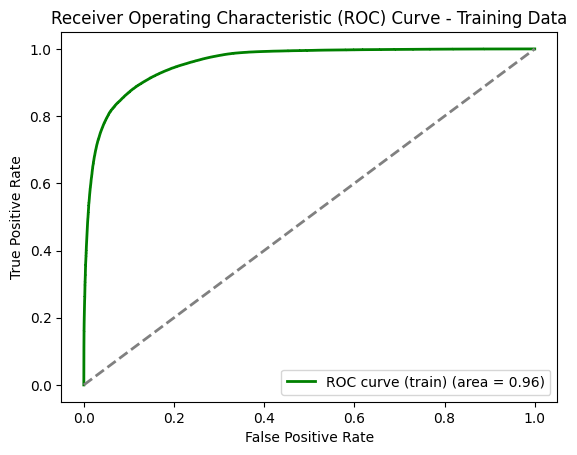

In [20]:
import xgboost as xgb

# XGBoost model
model = xgb.XGBClassifier(
    max_depth=6,                  
    learning_rate=0.1,            
    n_estimators=100,            
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), 
    random_state=42
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7874665854566373
Test Log Loss: 0.3760072505551629
Test ROC AUC: 0.8499111478717934
Test Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.68      0.49      9034
           1       0.93      0.81      0.87     50072

    accuracy                           0.79     59106
   macro avg       0.66      0.74      0.68     59106
weighted avg       0.85      0.79      0.81     59106

Class 0 Test Accuracy: 0.6761124640247952
Class 1 Test Accuracy: 0.8075571177504394
Train Accuracy: 0.8814216391635796
Train Log Loss: 0.26643414008257643
Train ROC AUC: 0.9563542942604181
Train Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88    130652
           1       0.89      0.88      0.88    130652

    accuracy                           0.88    261304
   macro avg       0.88      0.88      0.88    261304
weighted avg       0.88      0.88      0.88    261304


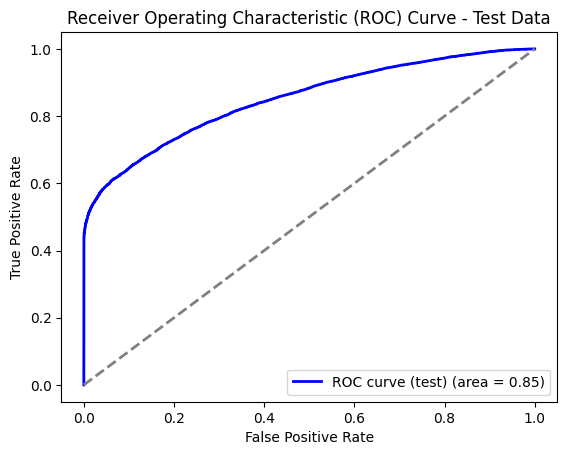

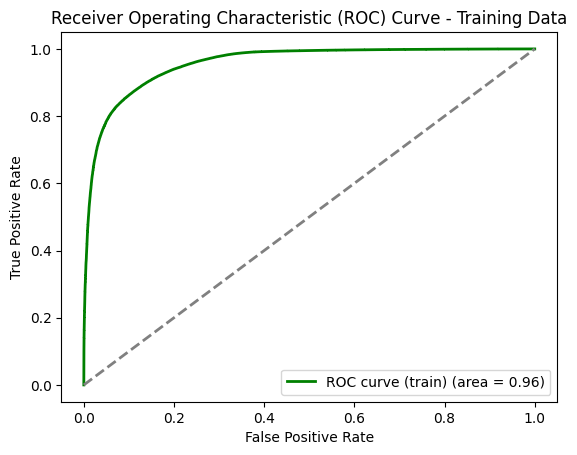

In [21]:
model = xgb.XGBClassifier(
    max_depth=5,                   # Slightly shallower trees
    learning_rate=0.05,            # Slower learning rate
    n_estimators=200,              # More boosting rounds
    subsample=0.8,                 # Use 80% of data for each tree
    colsample_bytree=0.8,          # Use 80% of features for each tree
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  # Handle class imbalance
    gamma=0.1,                     # Regularization to prevent overfitting
    random_state=42
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.793591175176801
Test Log Loss: 0.37878054365578523
Test ROC AUC: 0.8403904388307359
Test Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.60      0.47      9034
           1       0.92      0.83      0.87     50072

    accuracy                           0.79     59106
   macro avg       0.65      0.72      0.67     59106
weighted avg       0.84      0.79      0.81     59106

Class 0 Test Accuracy: 0.6028337392074385
Class 1 Test Accuracy: 0.8280076689567023
Train Accuracy: 0.8830366163548969
Train Log Loss: 0.2664282236799839
Train ROC AUC: 0.9565619321572247
Train Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88    130652
           1       0.89      0.88      0.88    130652

    accuracy                           0.88    261304
   macro avg       0.88      0.88      0.88    261304
weighted avg       0.88      0.88      0.88    261304



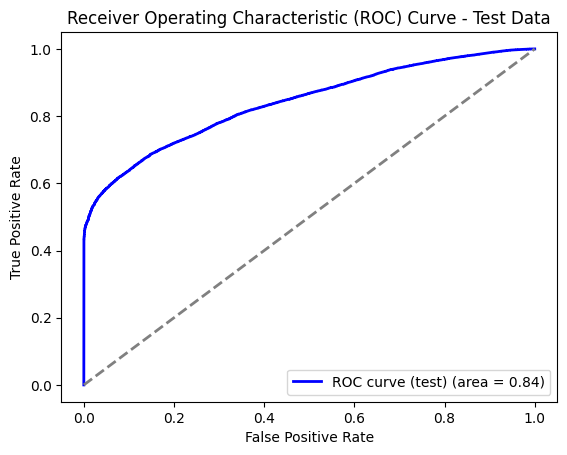

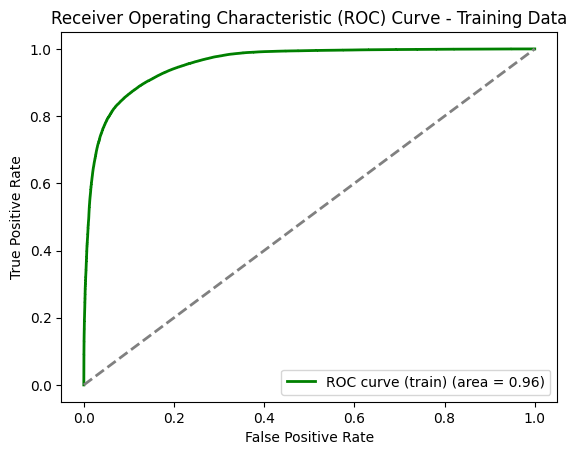

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

# GBM model
model = GradientBoostingClassifier(
    max_depth=5,                    # Same depth as XGBoost for comparison
    learning_rate=0.05,             # Learning rate
    n_estimators=200,               # Number of boosting rounds
    subsample=0.8,                  # Use 80% of data for each tree
    random_state=42                 # Random state for reproducibility
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.8147396203431124
Test Log Loss: 0.35561142281708635
Test ROC AUC: 0.8603139009160437
Test Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.63      0.51      9034
           1       0.93      0.85      0.89     50072

    accuracy                           0.81     59106
   macro avg       0.68      0.74      0.70     59106
weighted avg       0.85      0.81      0.83     59106

Class 0 Test Accuracy: 0.6328315253486827
Class 1 Test Accuracy: 0.8475595142994089
Train Accuracy: 0.8870664054128524
Train Log Loss: 0.2577976550305286
Train ROC AUC: 0.9594872823382454
Train Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89    130652
           1       0.89      0.88      0.89    130652

    accuracy                           0.89    261304
   macro avg       0.89      0.89      0.89    261304
weighted avg       0.89      0.89      0.89    261304


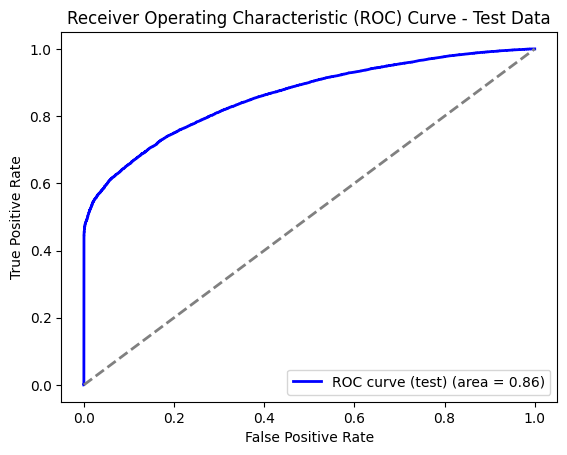

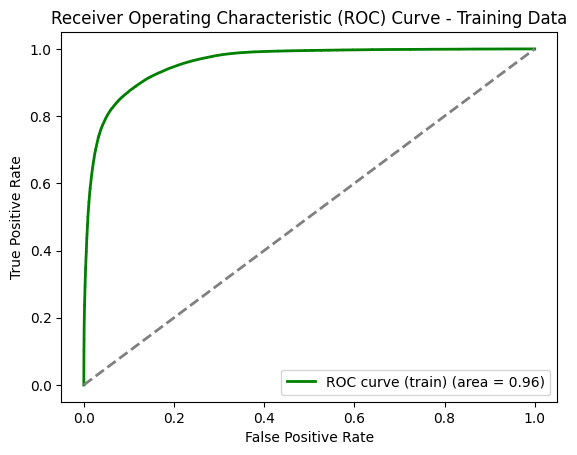

In [23]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt

# GBM model
model = GradientBoostingClassifier(
    max_depth=6,                    
    learning_rate=0.1,              
    n_estimators=100,              
    random_state=42                 
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

# AdaBoost model with a DecisionTreeClassifier as the base estimator
model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=6),  
    learning_rate=0.1,                              
    n_estimators=100,                               
    random_state=42                                 
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

# CatBoost model
model = CatBoostClassifier(
    depth=6,                      
    learning_rate=0.1,            
    iterations=100,               
    random_seed=42,               
    verbose=0                     
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

# LightGBM model
model = LGBMClassifier(
    max_depth=6,                     # Equivalent to max_depth in AdaBoost
    learning_rate=0.1,               # Same learning rate as AdaBoost
    n_estimators=100,                # Equivalent to n_estimators
    random_state=42                  # Random state for reproducibility
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, log_loss, roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt

# Convert data to numeric types
X_train_numeric = np.array(X_train, dtype=np.float32)  
X_test_numeric = np.array(X_test, dtype=np.float32)    
y_train_numeric = np.array(y_train, dtype=np.float32)  
y_test_numeric = np.array(y_test, dtype=np.float32)    

# Reshape X_train and X_test to have a time step dimension (convert to 3D for RNN input)
X_train_reshaped = np.expand_dims(X_train_numeric, axis=1)  
X_test_reshaped = np.expand_dims(X_test_numeric, axis=1)

# Define the Simple RNN model
model = Sequential([
    SimpleRNN(32, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store history
history = model.fit(X_train_reshaped, y_train_numeric, epochs=20, batch_size=32, validation_data=(X_test_reshaped, y_test_numeric))

# Make predictions
y_pred_proba = model.predict(X_test_reshaped).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

# Check for NaN values in y_pred_proba or y_test_numeric
if np.isnan(y_pred_proba).any() or np.isnan(y_test_numeric).any():
    print("NaN values found in predictions or test labels.")
    y_pred_proba = np.nan_to_num(y_pred_proba)  
    y_test_numeric = np.nan_to_num(y_test_numeric)

# Evaluate the model
accuracy = accuracy_score(y_test_numeric, y_pred)
log_loss_value = log_loss(y_test_numeric, y_pred_proba)
roc_auc = roc_auc_score(y_test_numeric, y_pred_proba)
report = classification_report(y_test_numeric, y_pred)

# Print evaluation metrics
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

# Training accuracy and loss
train_accuracy = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
print(f"Training Accuracy: {train_accuracy}")
print(f"Training Loss: {train_loss}")

# Plot training & validation accuracy over epochs
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss over epochs
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_numeric, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, log_loss, roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt

# Define the LSTM model
model = Sequential([
    LSTM(32, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store history
history = model.fit(X_train_reshaped, y_train_numeric, epochs=20, batch_size=32, validation_data=(X_test_reshaped, y_test_numeric))

# Make predictions
y_pred_proba = model.predict(X_test_reshaped).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

# Check for NaN values in y_pred_proba or y_test_numeric
if np.isnan(y_pred_proba).any() or np.isnan(y_test_numeric).any():
    print("NaN values found in predictions or test labels.")
    y_pred_proba = np.nan_to_num(y_pred_proba) 
    y_test_numeric = np.nan_to_num(y_test_numeric)

# Evaluate the model
accuracy = accuracy_score(y_test_numeric, y_pred)
log_loss_value = log_loss(y_test_numeric, y_pred_proba)
roc_auc = roc_auc_score(y_test_numeric, y_pred_proba)
report = classification_report(y_test_numeric, y_pred)

# Print evaluation metrics
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

# Training accuracy and loss
train_accuracy = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
print(f"Training Accuracy: {train_accuracy}")
print(f"Training Loss: {train_loss}")

# Plot training & validation accuracy over epochs
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss over epochs
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_numeric, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, log_loss, roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt


# Define the GRU model
model = Sequential([
    GRU(32, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store history
history = model.fit(X_train_reshaped, y_train_numeric, epochs=20, batch_size=32, validation_data=(X_test_reshaped, y_test_numeric))

# Make predictions
y_pred_proba = model.predict(X_test_reshaped).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

# Check for NaN values in y_pred_proba or y_test_numeric
if np.isnan(y_pred_proba).any() or np.isnan(y_test_numeric).any():
    print("NaN values found in predictions or test labels.")
    y_pred_proba = np.nan_to_num(y_pred_proba)  
    y_test_numeric = np.nan_to_num(y_test_numeric)

# Evaluate the model
accuracy = accuracy_score(y_test_numeric, y_pred)
log_loss_value = log_loss(y_test_numeric, y_pred_proba)
roc_auc = roc_auc_score(y_test_numeric, y_pred_proba)
report = classification_report(y_test_numeric, y_pred)

# Print evaluation metrics
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

# Training accuracy and loss
train_accuracy = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
print(f"Training Accuracy: {train_accuracy}")
print(f"Training Loss: {train_loss}")

# Plot training & validation accuracy over epochs
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss over epochs
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_numeric, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print(X_train.dtypes)

In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold

# Define the AdaBoost model with a DecisionTreeClassifier as base estimator
model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=6),  # Mimicking max_depth of 6 like in XGBoost
    learning_rate=0.1,                              # Equivalent to XGBoost learning rate
    n_estimators=100,                               # Number of boosting rounds, same as XGBoost
    random_state=42                                 # Random state for reproducibility
)

# Set up stratified k-fold cross-validation (ensuring class balance in folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and capture metrics
cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring=['accuracy', 'roc_auc', 'neg_log_loss'], return_train_score=True)

# Output the results of cross-validation
print("Cross-Validation Results:")
print(f"Mean Test Accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"Mean Test ROC AUC: {cv_results['test_roc_auc'].mean():.4f}")
print(f"Mean Test Log Loss: {-cv_results['test_neg_log_loss'].mean():.4f}")
print(f"Mean Train Accuracy: {cv_results['train_accuracy'].mean():.4f}")
print(f"Mean Train ROC AUC: {cv_results['train_roc_auc'].mean():.4f}")
print(f"Mean Train Log Loss: {-cv_results['train_neg_log_loss'].mean():.4f}")

# Now fit the model on the entire training dataset and evaluate it
model.fit(X_train, y_train)

# Predictions and evaluation metrics as before
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Output the evaluation metrics
print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Test Log Loss: {log_loss_value:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")
print(f"Classification Report:\n{report}")